<h1  style="text-align: center">NYC Taxi Trip Duration</h1> 

## Problem Statement

At some point or the other almost each one of us has used an Ola or Uber for taking a ride. 

Ride hailing services are services that use online-enabled platforms to connect between passengers and local drivers using their personal vehicles. In most cases they are a comfortable method for door-to-door transport. Usually they are cheaper than using licensed taxicabs. Examples of ride hailing services include Uber and Lyft.

<img src="2560px-Ride_hailing_services_Wikivoyage_banner.jpg">

To improve the efficiency of taxi dispatching systems for such services, it is important to be able to predict how long a driver will have his taxi occupied. If a dispatcher knew approximately when a taxi driver would be ending their current ride, they would be better able to identify which driver to assign to each pickup request.


<h1  style="text-align: center">Exploratory Data Analysis</h1> 

Now, we are going to dive dipper into the data, according to the data description we have the following columns:

 - **id**: a unique identifier for each trip
 - **vendor_id**: a code indicating the provider associated with the trip record
 - **pickup_datetime**: date and time when the meter was engaged
 - **dropoff_datetime**: date and time when the meter was disengaged
 - **passenger_count**: the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude**: the longitude where the meter was engaged
 - **pickup_latitude**: the latitude where the meter was engaged
 - **dropoff_longitude**: the longitude where the meter was disengaged
 - **dropoff_latitude**: the latitude where the meter was disengaged
 - **store_and_fwd_flag**: This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration**: (target) duration of the trip in seconds

Here, we have 2 variables dropoff_datetime and store_and_fwd_flag which are not available before the trip starts and hence will not be used as features to the model.

### Loading important libraries for analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt           ## Plotting libraries
import seaborn as sns
sns.set()                                ## Makes all matplotlib plots set in seaborn style
import scipy.stats as stats              # For Statistical Analysis and hypothesis testing
from datetime import timedelta         ## Date Time libraries
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('nyc_taxi_trip_duration.csv')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [4]:
print(f'Our data has {df.shape[0]} rows and {df.shape[1]} features.')

Our data has 729322 rows and 11 features.


<h1  style="text-align: center">Datatype Information</h1>

In [5]:
df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [6]:
print(f'There are {df.dtypes.value_counts()[0]} "Object" (Categorical) variables, {df.dtypes.value_counts()[1]} "float64" (Numerical) and {df.dtypes.value_counts()[2]} "int64" (Numerical) variables.')

There are 4 "Object" (Categorical) variables, 4 "float64" (Numerical) and 3 "int64" (Numerical) variables.


We can drop the column 'id' as it has all the values unique, which would be not helpful in making any prediction later.

In [7]:
del(df['id'])        ## Deleting the 'id' column from the dataframe

In [8]:
df.head()         

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


<h1  style="text-align: center" >Missing Values</h1>

In [9]:
df.isna().sum()

vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Fortunately, we do not have any missing values in our data.

### Reformatting features & Checking consistency
There are a variety of features within the dataset and it is important to convert them into the right format such that we can analyse them easily. This would include converting datetime features and string features. 

Also, one important thing is never to take assumptions without backing it with data. Here, as you can see the trip duration can also be calculated pick up and drop off datetime. We will check whether the given duration is consistent with the calculated trip duration.

In [10]:
# converting strings to datetime features
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

# Converting yes/no flag to 1 and 0
df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values == 'Y')

df['check_trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).map(lambda x: x.total_seconds())

duration_difference = df[np.abs(df['check_trip_duration'].values  - df['trip_duration'].values) > 1]
duration_difference.shape

(0, 11)

In [11]:
## Will be mapping the store_and_fwd_flag column to numerical values, just before the model building
df['vendor_id'] = df['vendor_id'].astype('object')  ## Because, vendor_id is a category
df.dtypes     ## Now, the datatypes are fine

vendor_id                      object
pickup_datetime        datetime64[ns]
dropoff_datetime       datetime64[ns]
passenger_count                 int64
pickup_longitude              float64
pickup_latitude               float64
dropoff_longitude             float64
dropoff_latitude              float64
store_and_fwd_flag              int32
trip_duration                   int64
check_trip_duration           float64
dtype: object

### TARGET EXPLORATION

In [12]:
df['trip_duration'].describe()/3600 # Trip duration in hours

count    202.589444
mean       0.264508
std        1.073507
min        0.000278
25%        0.110278
50%        0.184167
75%        0.298611
max      538.815556
Name: trip_duration, dtype: float64

There is a trip with duration of 979 hours. This is a huge outlier and might create problems at the prediction stage. One idea is to log transform the trip duration before prediction to visualise it better.

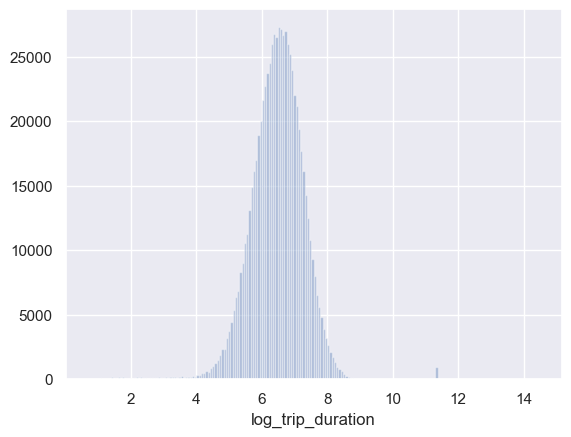

In [13]:
df['log_trip_duration'] = np.log(df['trip_duration'].values + 1)
sns.distplot(df['log_trip_duration'], kde = False, bins = 200)
plt.show()

We find:

1. The majority of rides follow a rather smooth distribution that looks almost log-normal with a peak just around exp(6.5)  i.e. about 17 minutes.
2. There are several suspiciously short rides with less than 10 seconds duration.
3. As discussed earlier, there are a few huge outliers near 12.

### Univariate Visualization
First of all, let us look at some of the binary features. Looking at each feature might uncover some insight that might be useful at later modelling stages

In [14]:
## Selecting Categorical and Numerical Columns 

cat_cols = df.select_dtypes(include = np.object).columns.tolist() ## Removing ID as it is not really needed
num_cols = df.select_dtypes(exclude = np.object).columns.tolist()

print('******************************Categorical Columns****************************')
print(cat_cols)
print(' ')
print('******************************Numerical Columns****************************')
print(num_cols)

******************************Categorical Columns****************************
['vendor_id']
 
******************************Numerical Columns****************************
['pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'check_trip_duration', 'log_trip_duration']


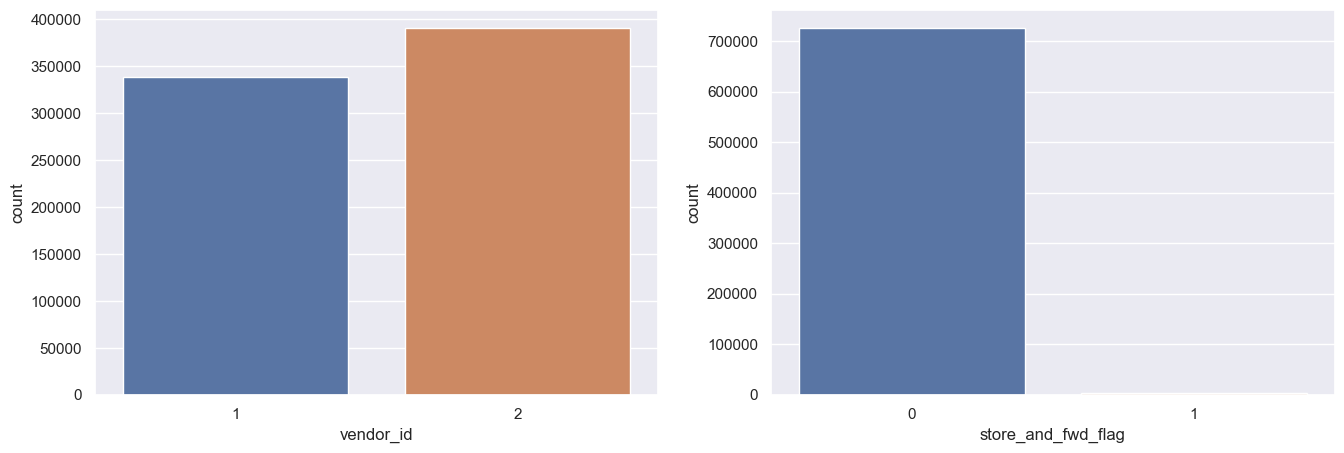

In [15]:
fig, ax = plt.subplots(1,2, figsize = (16, 5))      ## Categorical variables
sns.countplot(x = df['vendor_id'], ax = ax[0])
sns.countplot(x = df['store_and_fwd_flag'], ax = ax[1])
fig.show()

Text(0, 0.5, 'Frequency')

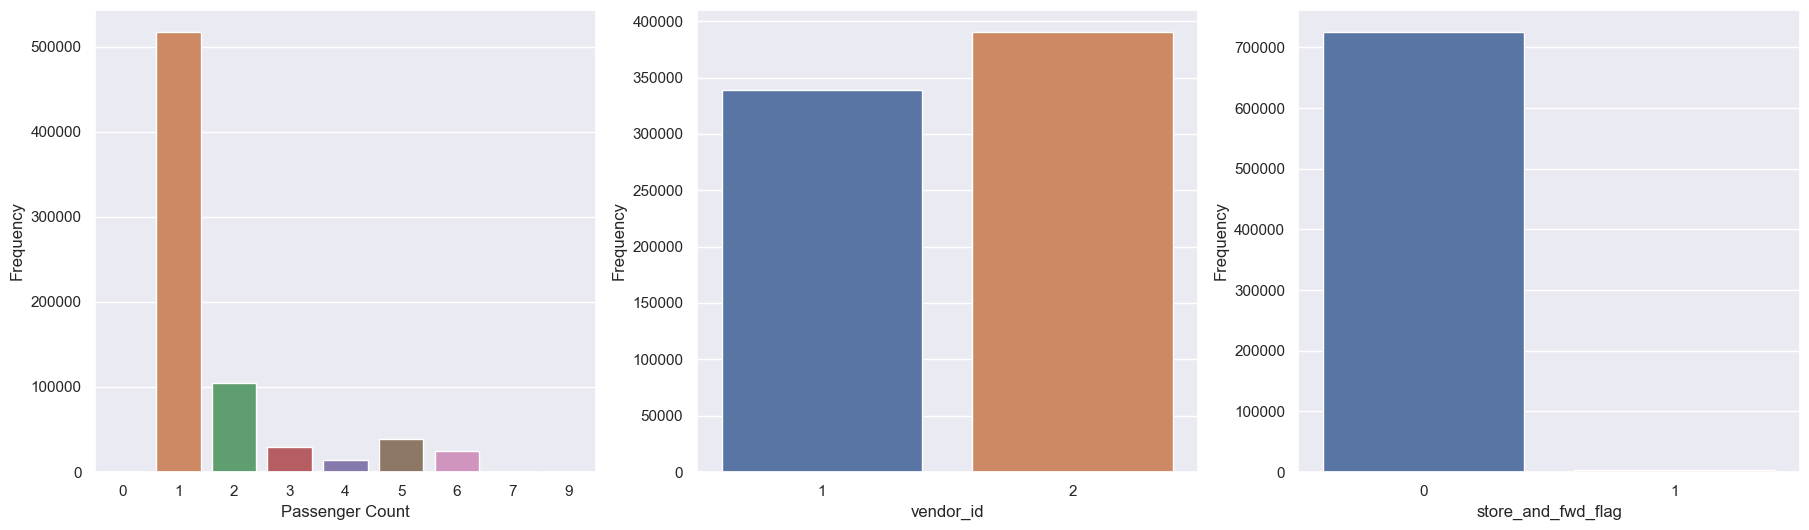

In [16]:
# Binary Features
plt.figure(figsize=(22, 6))
#fig, axs = plt.subplot(ncols=2)

# Passenger Count
plt.subplot(131)
sns.countplot(x = df['passenger_count'])
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')


# vendor_id
plt.subplot(132)
sns.countplot(x = df['vendor_id'])
plt.xlabel('vendor_id')
plt.ylabel('Frequency')

# store_and_fwd_flag
plt.subplot(133)
sns.countplot(x = df['store_and_fwd_flag'])
plt.xlabel('store_and_fwd_flag')
plt.ylabel('Frequency')


Observations:
1. Most of the trips involve only 1 passenger. There are trips with 7-9 passengers but they are very low in number.
2. Vendor 2 has more number of trips as compared to vendor 1
3. The store_and_fwd_flag values, indicating whether the trip data was sent immediately to the vendor (“0”) or held in the memory of the taxi because there was no connection to the server (“1”), show that there was almost no storing taking place

## Looking into Datetime variables

In [17]:
df['pickup_datetime'].min(), df['pickup_datetime'].max()   ## Min and max values for datetime

(Timestamp('2016-01-01 00:01:14'), Timestamp('2016-06-30 23:59:37'))

* It can be seen that we have have the data for a duration of 6 months, hence we can dive deeper into months, weekdays, hour of the day and other important features.

In [18]:
## Making new features for storing new values

df['day_of_week'] = df['pickup_datetime'].dt.weekday   # 0: Monday, 6: Sunday
df['hour_of_day'] = df['pickup_datetime'].dt.hour

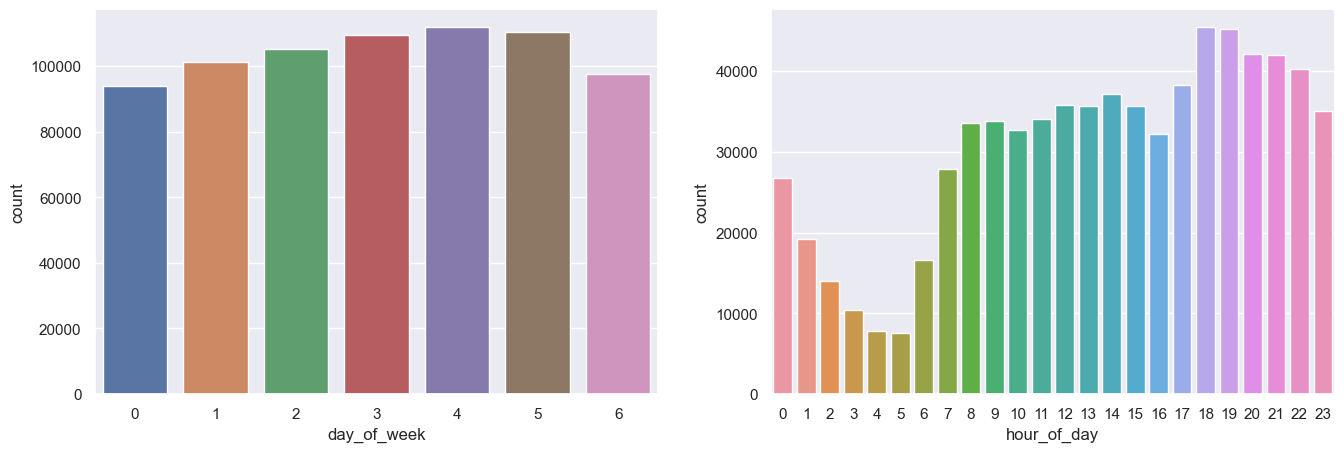

In [19]:
fig, ax = plt.subplots(1,2, figsize = (16, 5))      ## Categorical variables
sns.countplot(x = df['day_of_week'], ax = ax[0])
sns.countplot(x = df['hour_of_day'], ax = ax[1])
fig.show()

* Number of pickups for weekends is much lower than week days with a peak on Thursday (4). Note that here weekday is a decimal number, where 0 is Sunday and 6 is Saturday.
* Number of pickups as expected is highest in late evenings. However, it is much lower during the morning peak hours.

## Lattitude & Longitude

Lets look at the geospatial or location features to check consistency. They should not vary much as we are only considering trips within New York city.

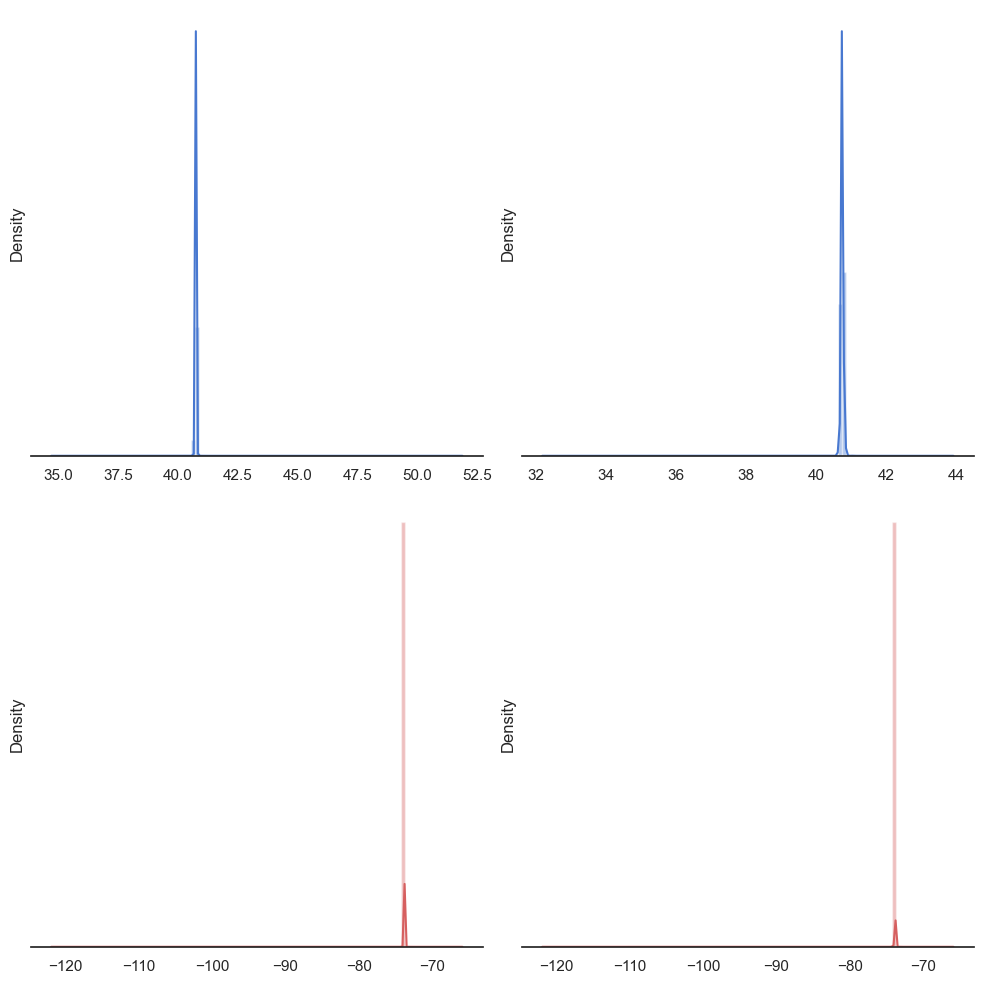

In [20]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(df['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[1,0])
sns.distplot(df['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[0,1])
sns.distplot(df['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1,1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

Findings - (Here, red represents pickup and dropoff Longitudes & blue represents pickup & dropoff lattitudes)

1. From the plot above it is clear that pick and drop latitude are centered around 40 to 41, and longitude are situated around -74 to -73. 
2. Some extreme co-ordinates has squeezed the plot such that we see a spike here
3. A good idea is to remove these outliers and look at the distribution more closely

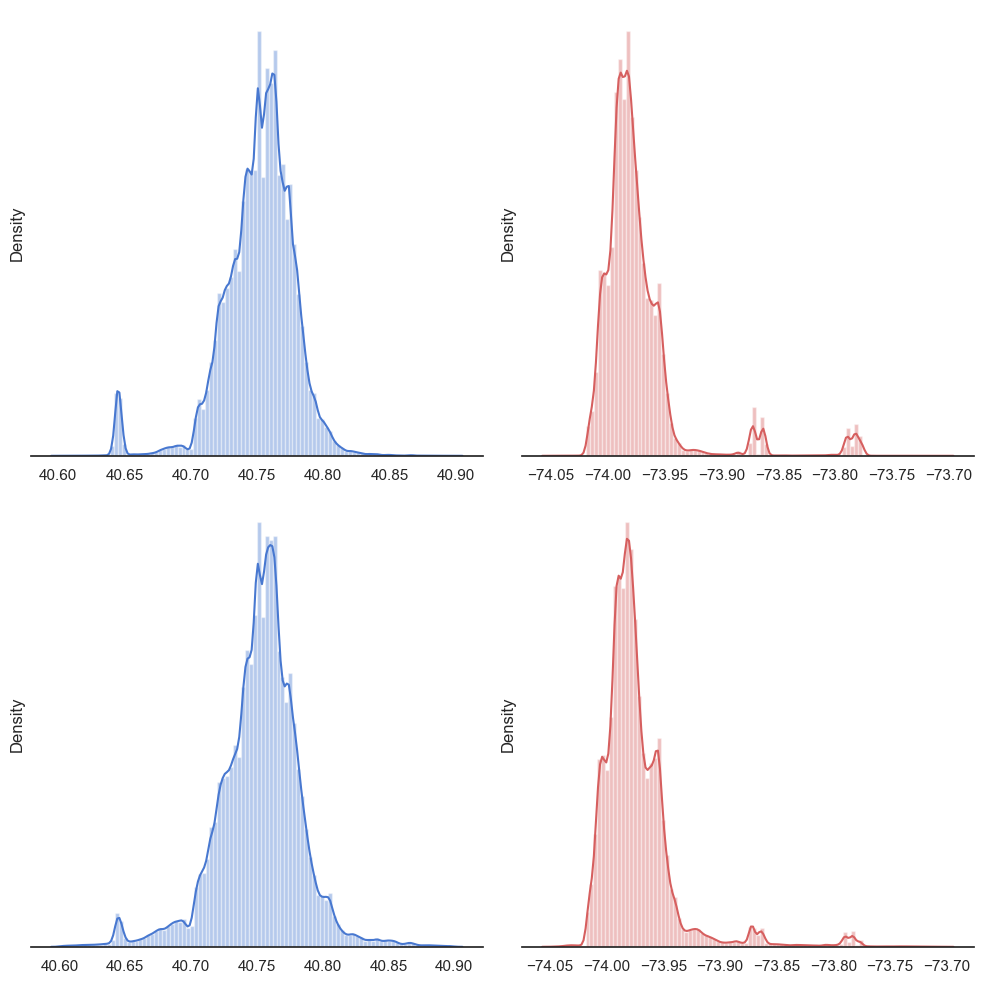

In [21]:
df = df.loc[(df.pickup_latitude > 40.6) & (df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
df_data_new = df.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(df_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[0,1])
sns.distplot(df_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[1, 0])
sns.distplot(df_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()

plt.show()

* We have a much better view of the distribution of coordinates instead of spikes. And we see that most trips are concentrated between these lat long only with a few significant clusters.
* These clusters are represented by the numerous peaks in the lattitude and longitude histograms

### Bivariate Relations with Target
Now that we have gone through all the basic features one by one. Let us start looking at their relation with the target. This will help us in selecting and extracting features at the modelling stage.

In [22]:
df.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'check_trip_duration', 'log_trip_duration', 'day_of_week',
       'hour_of_day'],
      dtype='object')

### Trip Duration vs Weekday

For different week days, the trip durations can vary as different week days might have different traffic densities especially the weekends might have a much different patterns as compared to working days. Weekday is taken as a decimal number, where 0 - Sunday and 6 is Saturday.

In [83]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['day_of_week'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(data=summary_wdays_avg_duration, x="day_of_week", y="trip_duration",figsize = (10,5))
sns.despine(bottom = False)

KeyError: 'day_of_week'

AttributeError: 'Line2D' object has no property 'figsize'

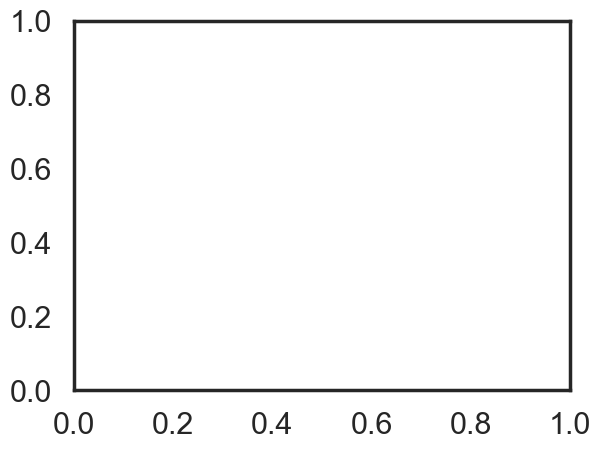

In [84]:
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(data=summary_wdays_avg_duration, x="day_of_week", y="trip_duration",figsize = (10,5))
sns.despine(bottom = False)

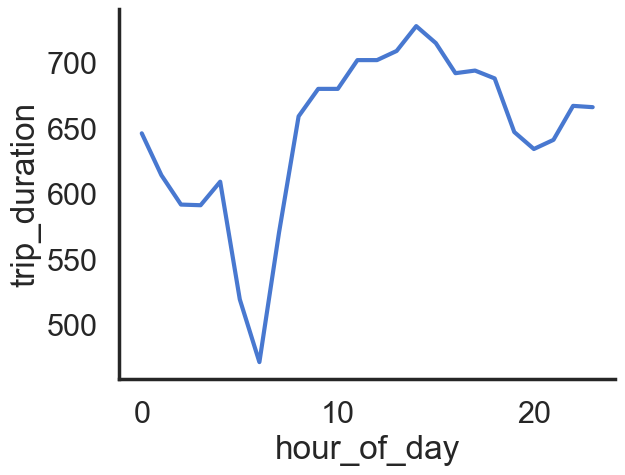

In [24]:
summary_hourly_avg_duration = pd.DataFrame(df.groupby(['hour_of_day'])['trip_duration'].median())
summary_hourly_avg_duration.reset_index(inplace = True)
summary_hourly_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(data=summary_hourly_avg_duration, x="hour_of_day", y="trip_duration")
sns.despine(bottom = False)

AttributeError: 'Line2D' object has no property 'figsize'

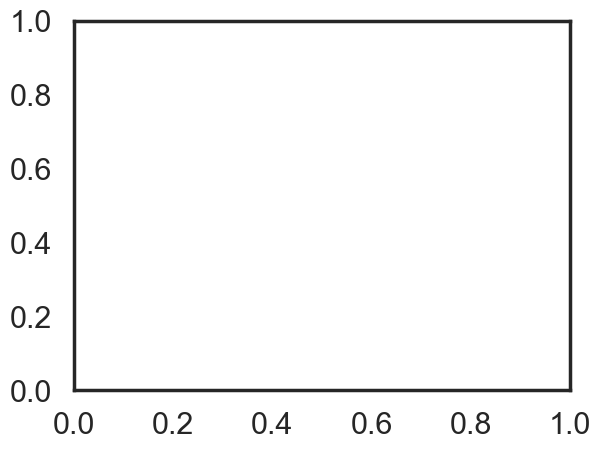

In [85]:
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(data=summary_hourly_avg_duration, x="hour_of_day", y="trip_duration",figsize=(10,5))
sns.despine(bottom = False)

* Trip durations are definitely shorter for late night and early morning hours that can be attributed to low traffic density
* It follows a similar pattern when compared to number of pickups indicating a correlation between number of pickups and trip duration

### vendor_id vs Trip Duration

Let's check how the trip duration varies for different vendors.

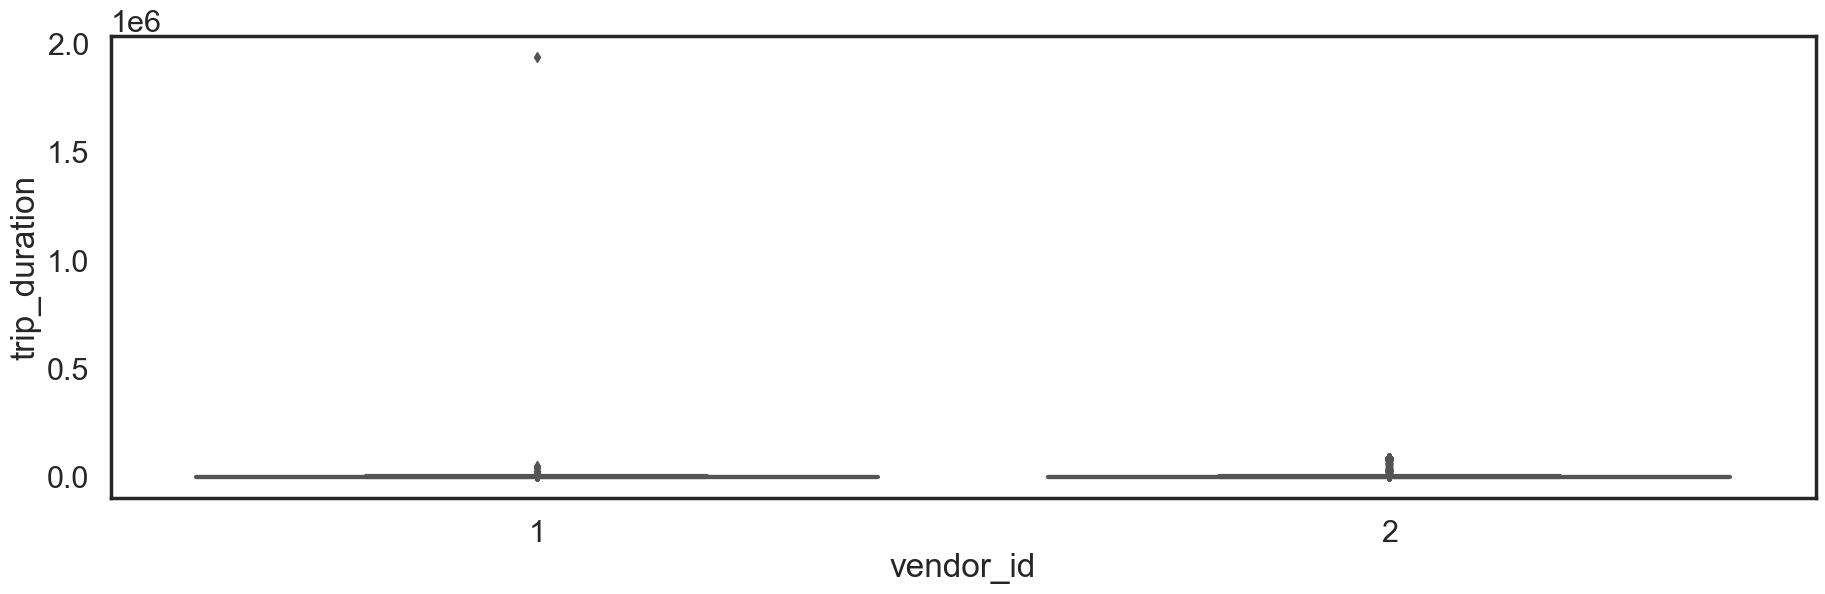

In [25]:
plt.figure(figsize=(22, 6))
sns.boxplot(x="vendor_id", y="trip_duration", data=df)
plt.show()

This did not came out as expected. The only thing I can see from this boxplot is that for vendor 2, there are a number of outliers exceeding 24 hours while vendor 1 does not have such long trips.

There could be 2 solutions to this:
1. Remove the huge outliers and plot again 
2. Look at median trip duration for both vendors on hourly basis

Let's try the first technique now and check trips below 50000 seconds only

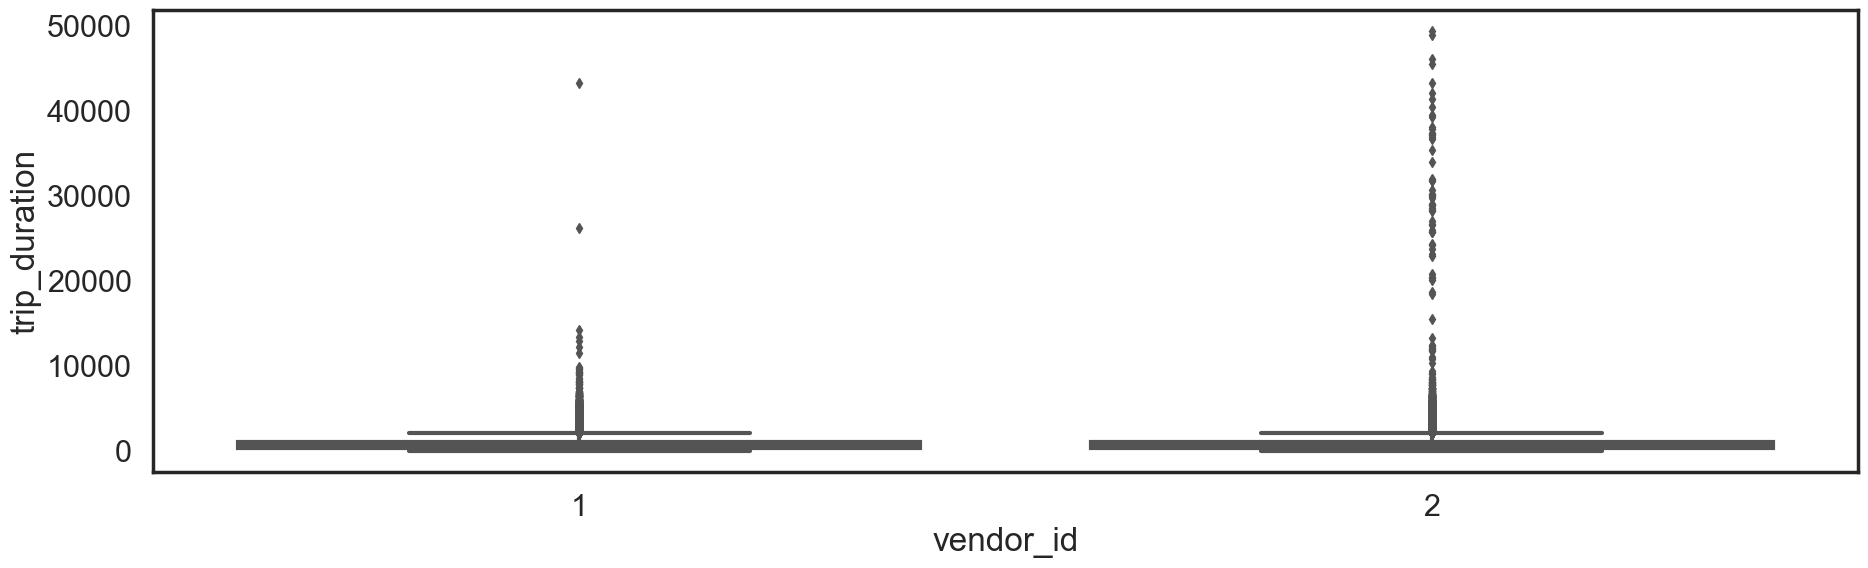

In [26]:
plt.figure(figsize=(22, 6))
df_sub = df[df['trip_duration'] < 50000]
sns.boxplot(x="vendor_id", y="trip_duration", data=df_sub)
plt.show()

As you can see, we were in a false perception earlier that vendor 1 had more outliers. Since the median is just around 600 seconds, we observe that vendor 2 has many more outliers as compared to vendor 1. Next, to confirm this, we will quickly look at the mean wrt day of week for both vendors using tsplot (time series plot) from seaborn.

### Mean Trip Duration Vendor Wise

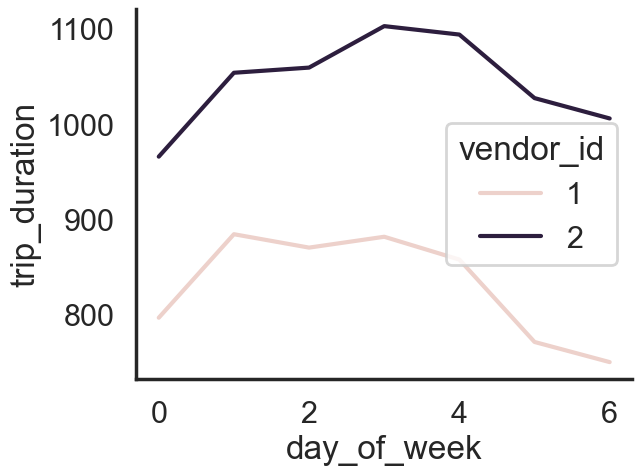

In [27]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(data=summary_wdays_avg_duration, x="day_of_week", y="trip_duration", hue = "vendor_id")
sns.despine(bottom = False)


### Median Trip Duration Vendor Wise

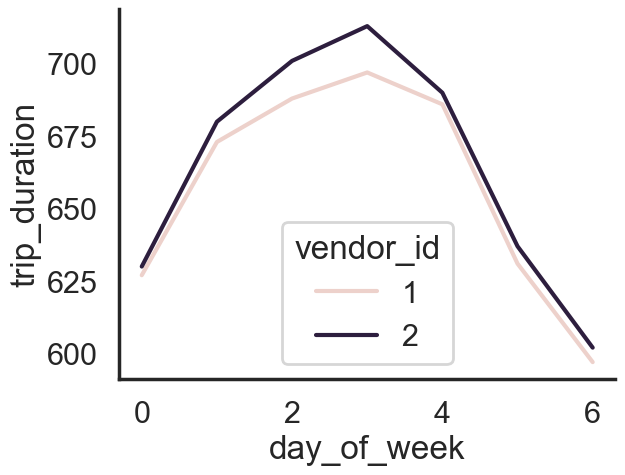

In [28]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['vendor_id','day_of_week'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(data=summary_wdays_avg_duration, x="day_of_week", hue="vendor_id", y="trip_duration")
sns.despine(bottom = False)

Median trip duration does not vary much as can be seen from the above plot for different vendors. It emphasises the importance of looking at the correct measure for central tendency for analysis.

### Trip Duration vs Passenger Count

Again as we are aware, there are a large number of outliers for trip duration and we will not be able to observe the differences. For this, we have taken a cutoff of 10000 seconds and used a boxplot.

In [29]:
df.passenger_count.value_counts()

1    515243
2    104576
5     38776
3     29561
6     24035
4     13972
0        31
9         1
Name: passenger_count, dtype: int64

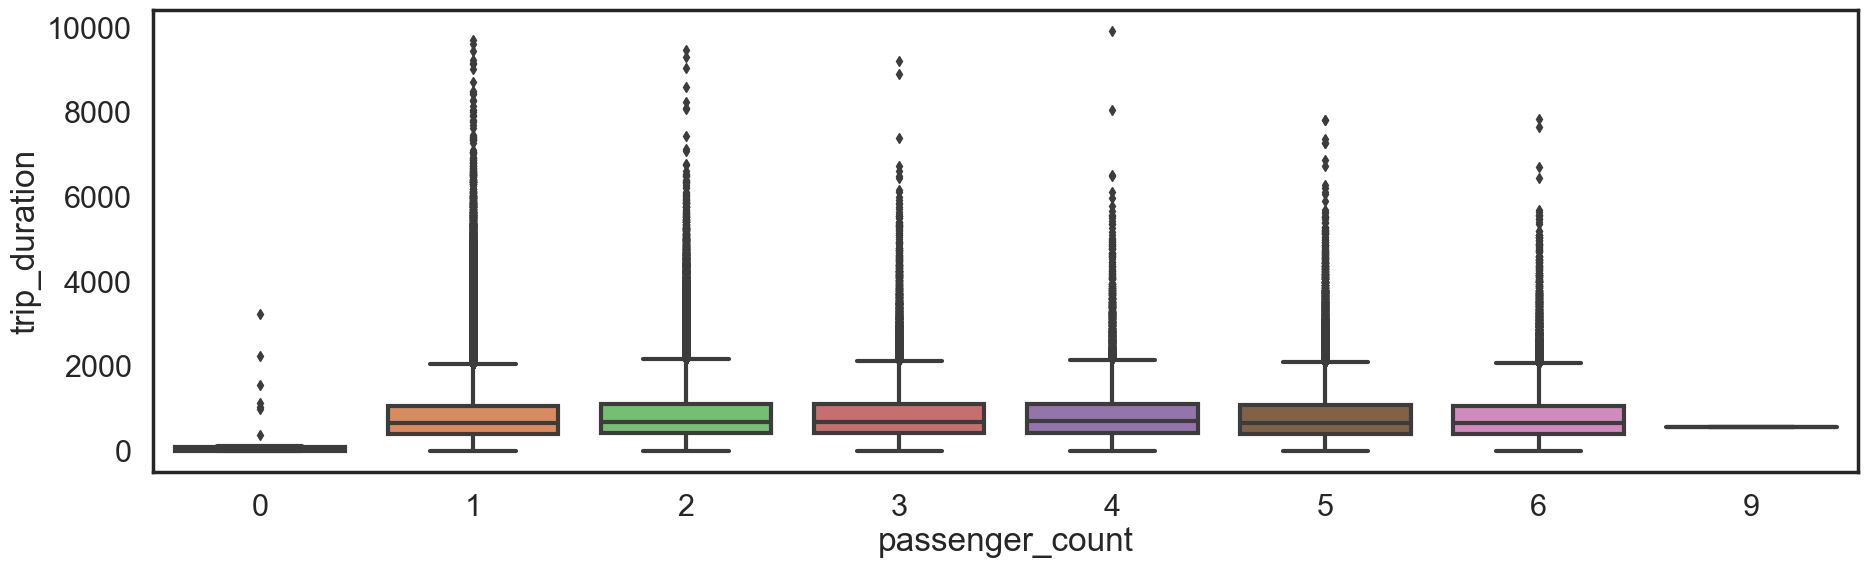

In [30]:
df.passenger_count.value_counts()
plt.figure(figsize=(22, 6))
df_sub = df[df['trip_duration'] < 10000]
sns.boxplot(x="passenger_count", y="trip_duration", data=df_sub)
plt.show()

* The boxplot clearly shows that there not much of a difference in distribution for the most frequently occuring passenger count values - 1, 2, 3.
* Another key observation is that the number of outliers are reduced for higher passenger counts but that only comes down to the individual frequencies of each passenger count.

### Visualise most frequently occuring Pickup points on the lattitude-longitude Map

Here, we try to visualise the most frequently occuring pickup points on the map and check how it is distributed spatially.

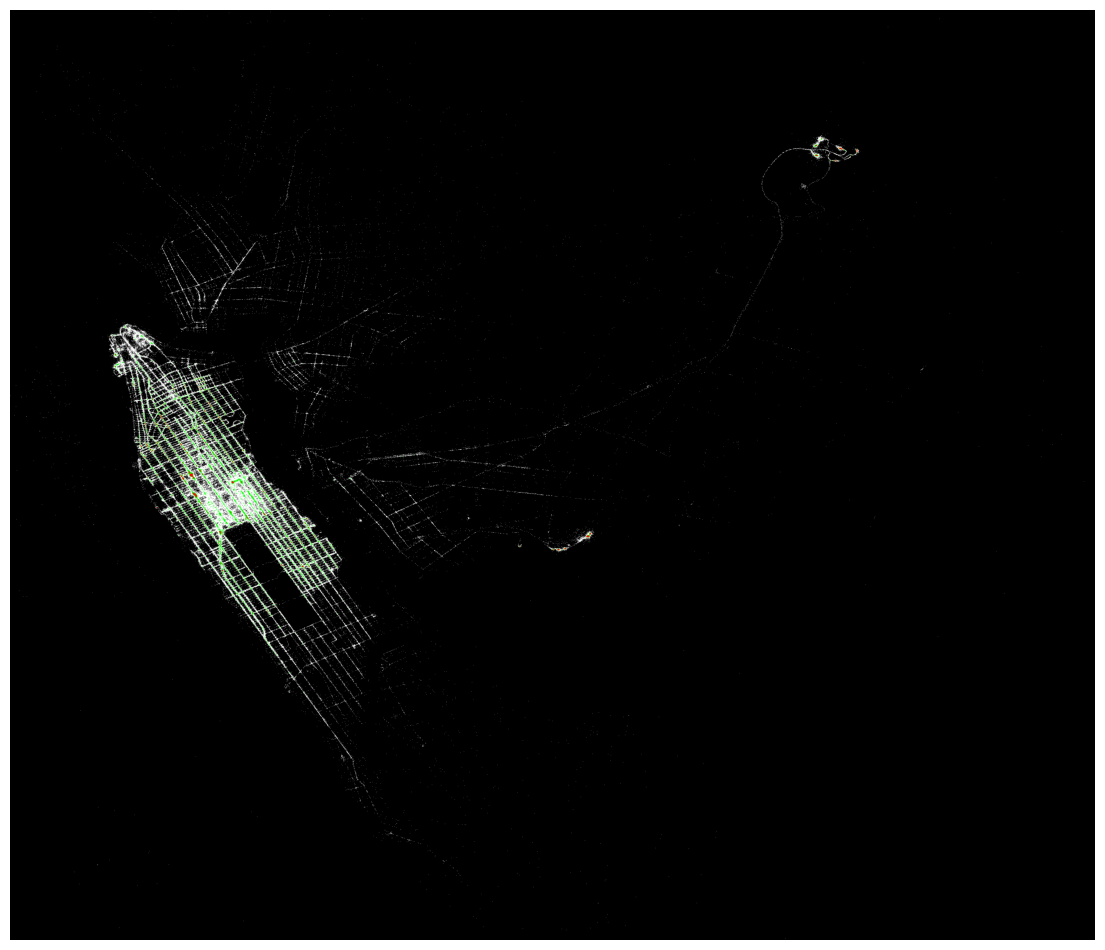

In [31]:
rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
rgb[..., 0] = 0
rgb[..., 1] = 0
rgb[..., 2] = 0
df_data_new['pick_lat_new'] = list(map(int, (df['pickup_latitude'] - (40.6000))*10000))
df_data_new['drop_lat_new'] = list(map(int, (df['dropoff_latitude'] - (40.6000))*10000))
df_data_new['pick_lon_new'] = list(map(int, (df['pickup_longitude'] - (-74.050))*10000))
df_data_new['drop_lon_new'] = list(map(int,(df['dropoff_longitude'] - (-74.050))*10000))

summary_plot = pd.DataFrame(df_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['vendor_id'].count())

summary_plot.reset_index(inplace = True)
summary_plot.head(120)
lat_list = summary_plot['pick_lat_new'].unique()
for i in lat_list:
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['vendor_id'].tolist()
    for j in lon_list:
        a = unit[lon_list.index(j)]
        if (a//25) >0:
            rgb[i][j][0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
        elif (a//10)>0:
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        else:
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 255
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
ax.imshow(rgb, cmap = 'hot')
ax.set_axis_off() 

Findings - From the heatmap kind of image above -

* White points - 1-10 trips have white as pickup point
* Green points - 10-25 trips have green as pickup point
* Red points - More than 25 trips have red as pickup point

As expected there are a few small clusters for hot pickup points as displayed by red in the above plot. Most pickup points have less than 10 trips and distributed all over the city.

If you go and have a look at an actual map of New York City, red and green points are mostly concentrated around the Manhatten Area

### Correlation Heatmap

Let us quickly look at the correlation heatmap to check the correlations amongst all features.

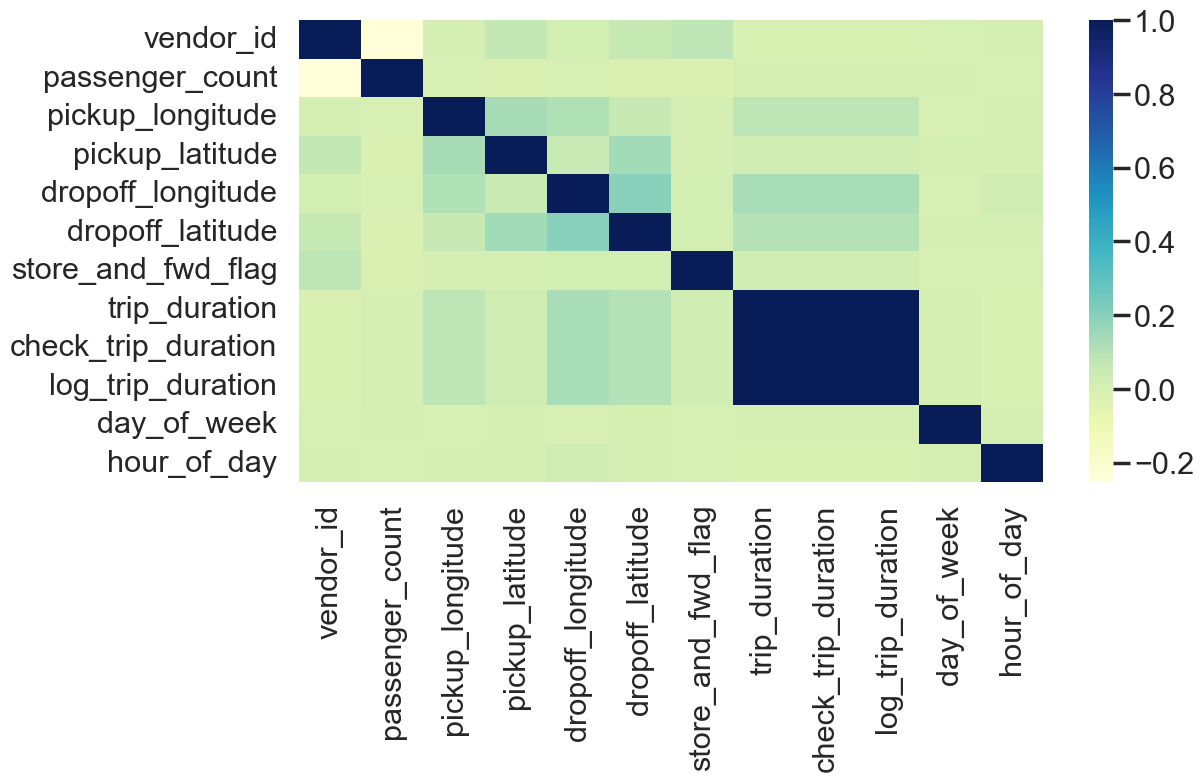

In [32]:
plt.figure(figsize=(12, 6))
df = df.drop(['pickup_datetime', 'dropoff_datetime'],
        axis=1)
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap="YlGnBu")

### Conclusions
1. The majority of rides follow a rather smooth distribution that looks almost log-normal with a peak just around exp(6.5)  i.e. about 17 minutes.
2. There are several suspiciously short rides with less than 10 seconds duration.
3. As discussed earlier, there are a few huge outliers near 12.
4. Most of the trips involve only 1 passenger. There are trips with 7-9 passengers but they are very low in number.
5. Vendor 2 has more number of trips as compared to vendor 1
6. Number of pickups for weekends is much lower than week days with a peak on Thursday (4). Note that here weekday is a decimal number, where 0 is Sunday and 6 is Saturday.
7. Number of pickups as expected is highest in late evenings. However, it is much lower during the morning peak hours.
8. We see that most trips are concentrated between these lat long only with a few significant clusters. These clusters are represented by the numerous peaks in the lattitude and longitude histograms
9. Trip durations are definitely shorter for late night and early morning hours that can be attributed to low traffic density
10. It follows a similar pattern when compared to number of pickups indicating a correlation between number of pickups and trip duration
11. Median trip duration does not vary much as can be seen from the above plot for different vendors.
12. The boxplot clearly shows that there not much of a difference in distribution for the most frequently occuring passenger count values - 1, 2, 3.
13. Another key observation is that the number of outliers are reduced for higher passenger counts but that only comes down to the individual frequencies of each passenger count.
14. From the correlation heatmap we see that the lattitude and longitude features have higher correlation with the target as compared to the other features.

<h1  style="text-align: center">Feature Engineering</h1>

We are done with understanding the overall distribution as well as derived some of the key insights out of the data. Now, we can start with model building but before that we can have try to build more feature to improve the performance of our model further. Below, are the features already available to us:

 - **id**: a unique identifier for each trip   (dropped)
 - **vendor_id**: a code indicating the provider associated with the trip record
 - **pickup_datetime**: date and time when the meter was engaged
 - **dropoff_datetime**: date and time when the meter was disengaged
 - **passenger_count**: the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude**: the longitude where the meter was engaged
 - **pickup_latitude**: the latitude where the meter was engaged
 - **dropoff_longitude**: the longitude where the meter was disengaged
 - **dropoff_latitude**: the latitude where the meter was disengaged
 - **store_and_fwd_flag**: This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration**: (target) duration of the trip in seconds

In [33]:
%matplotlib inline
import numpy as np 
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt        ## Visualisation

from sklearn.model_selection import train_test_split   # For splitting data into train and test

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression    ## Linear Regression
from sklearn.tree import DecisionTreeRegressor       ## Decision Tree
from sklearn.linear_model import Ridge, Lasso       ## Hyperparameters on Linear Regression
from sklearn.model_selection import KFold           ## For Cross-Validation
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [34]:
df = pd.read_csv('nyc_taxi_trip_duration.csv')      ## Loading the data again
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


For Feature Engineering, we can consider some more variables as:

* Distance between pickup-dropoff latitude will give us the distance towards x-axis, similarly pickup-dropoff longitude will give us the distance towards the y-axis. We can combine these both to find the 'Euclidean' distance which is based on Pythagorus theorem.

* Haversine Distance between the pickup and droppoff coordinates, to capture the real distance travelled by the taxi.

* Pickup Minute is the minute of the hour at which the passenger was picked up.

* Pcikup Day of the year, similar to the week of the year, can be an important variable.

In [35]:
## Datatype conversions

df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)    ## Converting to datatime datatype
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

In [36]:
# Log transform the Y values
df_y = np.log1p(df['trip_duration']) 

# Add some datetime features
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday         ## Day of the week for pickup
df['pickup_weekofyear'] = df['pickup_datetime'].dt.weekofyear     ## Week of the year
df['pickup_hour'] = df['pickup_datetime'].dt.hour               ## Hour of the day
df['pickup_minute'] = df['pickup_datetime'].dt.minute          ## Minute of the hour
df['pickup_dt'] = (df['pickup_datetime'] - df['pickup_datetime'].min()).dt.total_seconds()
df['pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']    ## Hour of the week at which the 
                                                                            ## passenger was picked up

<center> $\textbf{Distance Features (Euclidean and Haversine)}$ </center>

This will just give us some idea on the distance between the pickup and dropff points. But this surely is not the true distance as it does not consider the geography and the roads.

In [37]:
x_d = df['pickup_latitude'] - df['dropoff_latitude']        ## Distance in the x-axis
y_d = df['pickup_longitude'] - df['dropoff_longitude']      ## Distance in the y_axis

## Euclidean Distance
df['dist_sqrt'] = ((x_d)**2 + (y_d)**2) ** 0.5


#### Haversine Distance
Let's calculate the distance (km) between pickup and dropoff points. The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes. We will also calculate the approximate angle at which the dropoff location lies wrt the pickup location. pd.DataFrame.apply() would be too slow so the haversine function is rewritten to handle arrays.

<img src="haversine_dist.svg.png" width=200 height=200>

Haversine direction represents the information of angle of the line connecting the dropoff and pickup point over the surface of earth wrt equator.

In [38]:
## Function for Haversine Distance and the direction array

def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def direction_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


In [39]:
df['haversine_distance'] = haversine_array(df['pickup_latitude'].values, 
                                                     df['pickup_longitude'].values, 
                                                     df['dropoff_latitude'].values, 
                                                     df['dropoff_longitude'].values)


df['direction'] = direction_array(df['pickup_latitude'].values, 
                                          df['pickup_longitude'].values, 
                                          df['dropoff_latitude'].values, 
                                          df['dropoff_longitude'].values)



In [40]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,dist_sqrt,haversine_distance,direction
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400,0,9,16,40,5157547.0,16,0.012592,1.199073,-135.634530
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100,4,10,23,35,6132863.0,119,0.037371,4.129111,-172.445217
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635,6,7,17,59,4471099.0,161,0.072712,7.250753,34.916093
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141,1,1,9,44,380597.0,33,0.021473,2.361097,10.043567
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848,2,7,6,42,4084869.0,54,0.043264,4.328534,34.280582


### Fastest route by road
Sometimes, adding external information can be crucial for improving the model. Here we will use data extracted from The Open Source Routing Machine or OSRM for each trip in our original dataset. OSRM is a C++ implementation of a high-performance routing engine for shortest paths in road networks. This will give us a very good estimate of distances between pickup and dropoff Points

Source: http://project-osrm.org/

In [41]:
fr1 = pd.read_csv('osrm/fastest_routes_train_part_1.zip',
                  usecols=['id', 'total_distance', 'total_travel_time'])
fr2 = pd.read_csv('osrm/fastest_routes_train_part_2.zip',
                  usecols=['id', 'total_distance', 'total_travel_time'])

df_street_info = pd.concat((fr1, fr2))
df = df.merge(df_street_info, how='left', on='id')    ## Distance is in metres

df_street_info.head()

,id,total_distance,total_travel_time
0,id2875421,2009.1,164.9
1,id2377394,2513.2,332.0
2,id3504673,1779.4,235.8
3,id2181028,1614.9,140.1
4,id0801584,1393.5,189.4


In [42]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,dist_sqrt,haversine_distance,direction,total_distance,total_travel_time
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,...,9,16,40,5157547.0,16,0.012592,1.199073,-135.634530,1630.9,172.5
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,...,10,23,35,6132863.0,119,0.037371,4.129111,-172.445217,5428.7,581.8
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,...,7,17,59,4471099.0,161,0.072712,7.250753,34.916093,9327.8,748.9
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,...,1,9,44,380597.0,33,0.021473,2.361097,10.043567,8022.7,612.2
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,...,7,6,42,4084869.0,54,0.043264,4.328534,34.280582,5468.7,645.0


Now, we just need to round the values of latitudes and longitudes as they are a bit noisy due to their precision upto 6 decimal digits.

In [43]:
df['pickup_latitude_round'] = np.round(df['pickup_latitude'],3)
df['pickup_longitude_round'] = np.round(df['pickup_longitude'],3)

df['dropoff_latitude_round'] = np.round(df['dropoff_latitude'],3)
df['dropoff_longitude_round'] = np.round(df['dropoff_longitude'],3)

In [44]:
## One-Hot Encoding Vendor_id

df['vendor_id'] = df['vendor_id'].map({1: 1, 2: 0})

df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_week_hour,dist_sqrt,haversine_distance,direction,total_distance,total_travel_time,pickup_latitude_round,pickup_longitude_round,dropoff_latitude_round,dropoff_longitude_round
0,id1080784,0,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,...,16,0.012592,1.199073,-135.634530,1630.9,172.5,40.779,-73.954,40.771,-73.964
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,...,119,0.037371,4.129111,-172.445217,5428.7,581.8,40.732,-73.988,40.695,-73.995
2,id0857912,0,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,...,161,0.072712,7.250753,34.916093,9327.8,748.9,40.721,-73.997,40.775,-73.948
3,id3744273,0,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,...,33,0.021473,2.361097,10.043567,8022.7,612.2,40.760,-73.962,40.781,-73.957
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,...,54,0.043264,4.328534,34.280582,5468.7,645.0,40.708,-74.017,40.741,-73.988


In [45]:
df.isna().sum()

id                         0
vendor_id                  0
pickup_datetime            0
dropoff_datetime           0
passenger_count            0
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
store_and_fwd_flag         0
trip_duration              0
pickup_weekday             0
pickup_weekofyear          0
pickup_hour                0
pickup_minute              0
pickup_dt                  0
pickup_week_hour           0
dist_sqrt                  0
haversine_distance         0
direction                  0
total_distance             1
total_travel_time          1
pickup_latitude_round      0
pickup_longitude_round     0
dropoff_latitude_round     0
dropoff_longitude_round    0
dtype: int64

In [46]:
# For a route, the total distance and travel time are not available. Let's impute that with 0
df.fillna(0, inplace = True)

Before we go on to build a model, we must drop the variables that should not be fed as features to the algorithms. We will drop
* id - Uniquely represents a sample in the train set
* pickup_datetime - Since we have extracted the datetime features, there is no need to keep the datetime column
* dropoff_datetime - If this is used to create features, it would be a leakage and we will get perfect model performance. Why? The time gap between dropoff_datetime and pickup_datetime is essentially what we are trying to predict
* trip_duration - This is the target variable so needs to be dropped
* store_and_fwd_flag - This variable is not available before the start of the trip and should not be used for modelling.
* Pickup Coordinates and Dropoff Coordinates (original): As we are already having the rounded coordinates.

In [47]:
df = df.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration','store_and_fwd_flag', 'pickup_latitude',
             'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1)

<h1  style="text-align: center" >Model Building </h1>

In [48]:
df.head()

,vendor_id,passenger_count,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,dist_sqrt,haversine_distance,direction,total_distance,total_travel_time,pickup_latitude_round,pickup_longitude_round,dropoff_latitude_round,dropoff_longitude_round
0,0,1,0,9,16,40,5157547.0,16,0.012592,1.199073,-135.634530,1630.9,172.5,40.779,-73.954,40.771,-73.964
1,1,2,4,10,23,35,6132863.0,119,0.037371,4.129111,-172.445217,5428.7,581.8,40.732,-73.988,40.695,-73.995
2,0,2,6,7,17,59,4471099.0,161,0.072712,7.250753,34.916093,9327.8,748.9,40.721,-73.997,40.775,-73.948
3,0,6,1,1,9,44,380597.0,33,0.021473,2.361097,10.043567,8022.7,612.2,40.760,-73.962,40.781,-73.957
4,1,1,2,7,6,42,4084869.0,54,0.043264,4.328534,34.280582,5468.7,645.0,40.708,-74.017,40.741,-73.988


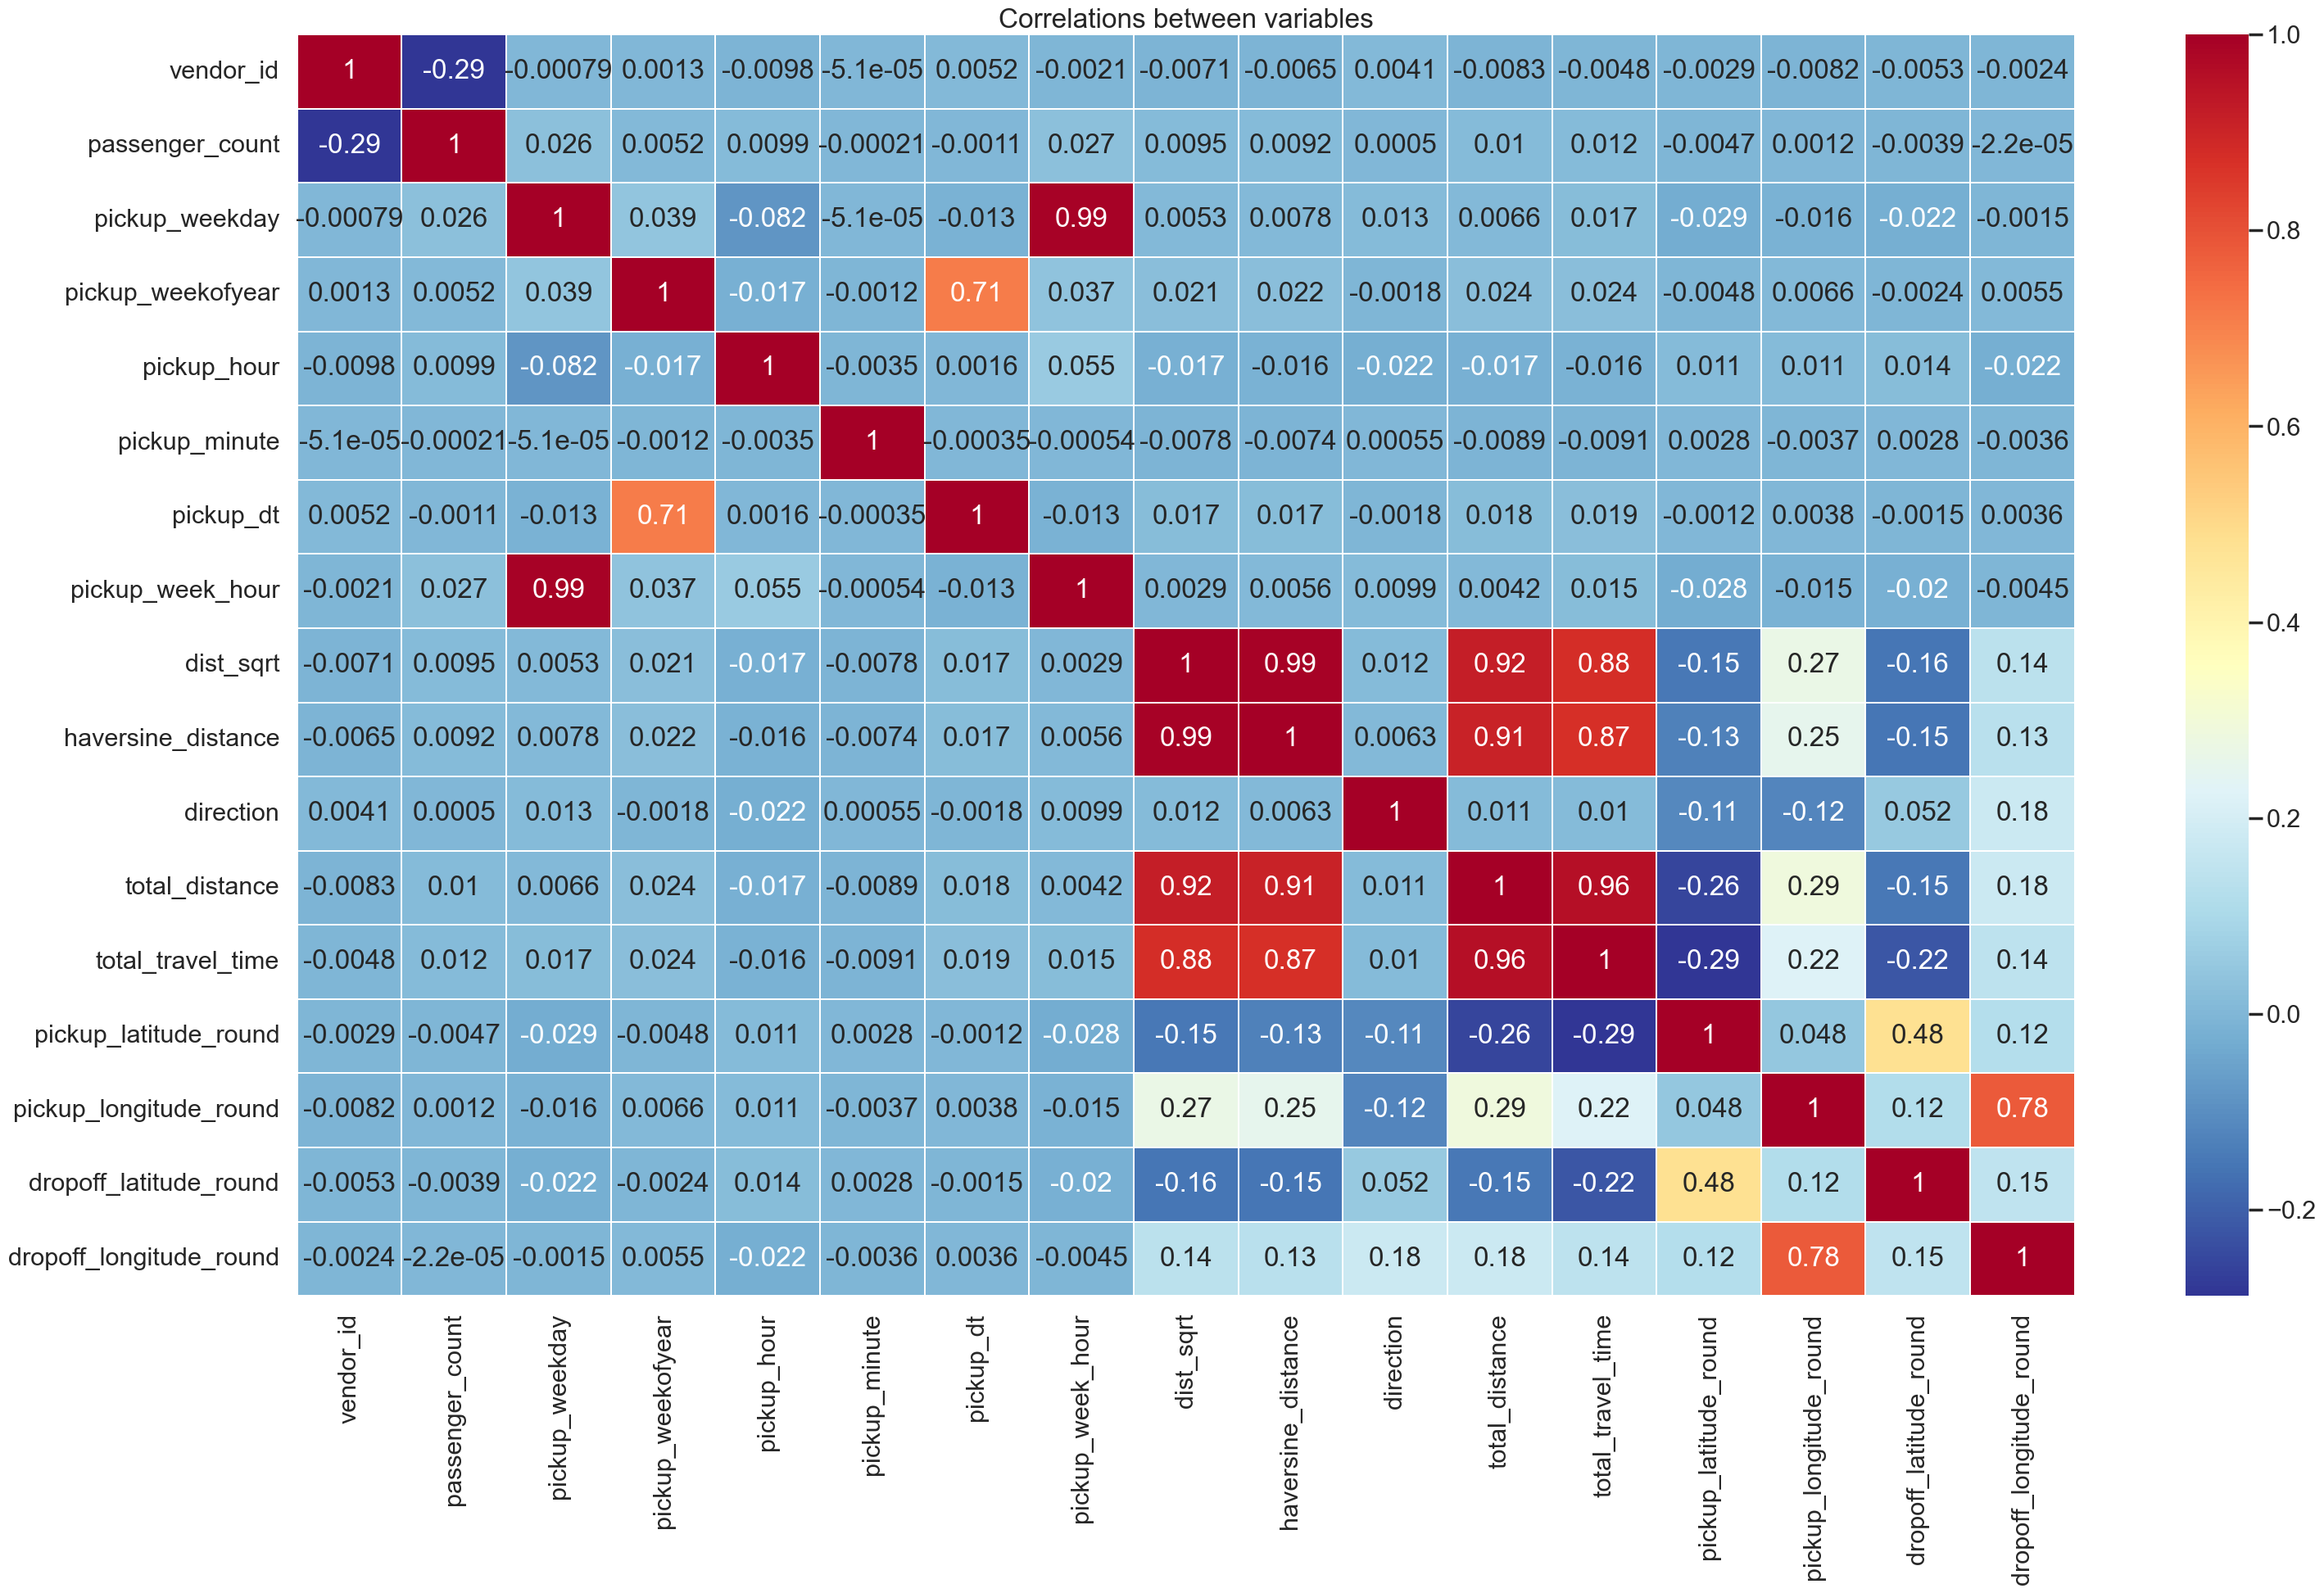

In [49]:
#Correlations between variables
fig, ax = plt.subplots(figsize=(35,20))  
sns.heatmap(data=df.corr(), annot=True, cmap = plt.cm.RdYlBu_r, linewidths=.1).set_title('Correlations between variables');

In [50]:
from sklearn.metrics import mean_squared_error       ## Error metric
from math import sqrt

In [51]:
#Splitting the data into Train and Validation set

from sklearn.model_selection import train_test_split 
xtrain, xtest, ytrain, ytest = train_test_split(df, df_y, test_size = 0.2, random_state=0)

<center> $\textbf{Baseline Model}$ </center>

In [52]:
mean_pred = np.repeat(ytrain.mean(),len(ytest))

sqrt(mean_squared_error(ytest, mean_pred))

0.8008351581959263

### Cross validation
Cross Validation is one of the most important concepts in any type of data modelling. It simply says, try to leave a sample on which you do not train the model and test the model on this sample before finalizing the model.

we divide the entire population into k equal samples. Now we train models on k-1 samples and validate on 1 sample. Then, at the second iteration we train the model with a different sample held as validation. 

In k iterations, we have basically built model on each sample and held each of them as validation. This is a way to reduce the selection bias and reduce the variance in prediction power.

In [53]:
def cv_score(ml_model, rstate = 11,cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    kf = KFold(n_splits=5,random_state=rstate,shuffle=True)
    
    for train_index,test_index in kf.split(df1,df_y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[train_index],df1.loc[test_index]
        ytr,yvl = df_y[train_index],df_y[test_index]

        model = ml_model
        model.fit(xtr, ytr)
        train_val = model.predict(xtr)
        pred_val = model.predict(xvl)
        rmse_score_train = sqrt(mean_squared_error(ytr, train_val))
        rmse_score = sqrt(mean_squared_error(yvl, pred_val))
        sufix = ""
        msg = ""
        
        msg += "Valid RMSE: {:.3f}".format(rmse_score)
        print("{}".format(msg))
        # Save scores
        cv_scores.append(rmse_score)
        i+=1
        
    return cv_scores

### Linear Regression

Lets begin by using the simplest regression algorithm Linear regression to check the performance.

In [54]:
linreg_scores = cv_score(LinearRegression())


1 of kfold 5
Valid RMSE: 0.549

2 of kfold 5
Valid RMSE: 0.550

3 of kfold 5
Valid RMSE: 0.547

4 of kfold 5
Valid RMSE: 0.563

5 of kfold 5
Valid RMSE: 0.547


It can be seen that the Linear Regression Model performs better than the baseline model. Let us try this for Decision Tree.

### Decision Tree

In [55]:
dtree_scores = cv_score(DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25))


1 of kfold 5
Valid RMSE: 0.427

2 of kfold 5
Valid RMSE: 0.430

3 of kfold 5
Valid RMSE: 0.419

4 of kfold 5
Valid RMSE: 0.426

5 of kfold 5
Valid RMSE: 0.422


* Error in the Decision Tree is lesser than the Linear Regression Model as Decision Trees are not effected by Multicollinearity and there might be non-linear relationships between some of the variables.

### Decision Tree Visualization

In [56]:
from sklearn import tree
warnings.filterwarnings('ignore')

In [57]:
dtree = DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25)
dtree.fit(xtrain, ytrain)

DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25)

In [58]:
decision_tree = tree.export_graphviz(dtree,out_file='tree.dot',feature_names=xtrain.columns,max_depth=2,filled=True)
!dot -Tpng tree.dot -o tree.png

'dot' is not recognized as an internal or external command,
operable program or batch file.


Now, let us view the decision tree till depth 2 and find out the features at the root and the first node.

<img src="tree.png" width=500 height=500>

As is clear from the above decision tree the extra features added are adding a lot of value to our decision tree learning indicating that the additional features carry good value and are very important to the model.

### Lasso Regression Implementation

In [61]:
from sklearn.linear_model import Lasso      ## Takes care for Multicollinearity

X = df
y = df_y
names = X.columns

lasso = Lasso(alpha=0.01)
lasso_coef = lasso.fit(X, y).coef_

lasso.fit(xtrain, ytrain)
y_pred = lasso.predict(xtest)

sqrt(mean_squared_error(ytest, y_pred))      

0.5590366754857027

Lasso Implementation is also giving error similar to the Linear Regression Model. Hence, tree based models are better for our analysis.

### Random Forest

Random forests are an ensemble learning method for classification and regression that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

Considering that we got a much more improved performance with decision trees. It is worthwhile to check tree based ensemble techniques.

In [62]:
rf_params = {'random_state': 0, 'n_estimators': 19, 'max_depth': 11, 'n_jobs': -1, "min_samples_split": 43}
rf_scores = cv_score(RandomForestRegressor(**rf_params))


1 of kfold 5
Valid RMSE: 0.419

2 of kfold 5
Valid RMSE: 0.420

3 of kfold 5
Valid RMSE: 0.411

4 of kfold 5
Valid RMSE: 0.416

5 of kfold 5
Valid RMSE: 0.413


### XGBoost
Looking at the performance of Random forest, it would be a good idea to try XGBoost which is based on gradient boosting techniques and check performance. 

* First we will set the  hyperparameters for XGBoost and use cross validation to track and figure out the correct number of rounds so that it does not overfit.

* Later, we will fit the XGBoost Regressor using the number of rounds identified from the above step and check the cross validation scores

To find the approximate number of rounds for XGBoost, we will first create a validation set and check performance after each round.

In [63]:
#Splitting the data into df and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(df,df_y,test_size=1/3, random_state=0)

In [64]:
dtrain = xgb.DMatrix(xtrain, label=ytrain)
dvalid = xgb.DMatrix(xtest, label=ytest)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

Finally! We're ready to use XGBoost. You'll notice that this part is actually quite short. But only in code. It can take quite a while to iterate through the different parameters and different values of these parameters to better the outcome of the model. There are several ways to do this and we will cover this in a later module.

In [65]:
xgb_params = {}
xgb_params["objective"] = "reg:linear"
xgb_params['eval_metric'] = "rmse"
xgb_params["eta"] = 0.05
xgb_params["min_child_weight"] = 10
xgb_params["subsample"] = 0.9
xgb_params["colsample_bytree"] = 0.7
xgb_params["max_depth"] = 5
xgb_params['silent'] = 1
xgb_params["seed"] = 2019
xgb_params["nthread"] = -1
xgb_params["lambda"] = 2

xgb_model = xgb.train(xgb_params, dtrain, 10000, watchlist, early_stopping_rounds=50,
      maximize=False, verbose_eval=20)
print('Modeling RMSE %.5f' % xgb_model.best_score)

[18:43:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:43:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-rmse:5.72174	valid-rmse:5.71900
[20]	train-rmse:2.09582	valid-rmse:2.09505
[40]	train-rmse:0.85421	valid-rmse:0.85576
[60]	train-rmse:0.50016	valid-rmse:0.50443
[80]	train-rmse:0.42679	valid-rmse:0.43260
[100]	train-rmse:0.41109	valid-rmse:0.41758
[120]	train-rmse:0.40516	valid-rmse:0.41225
[140]	train-rmse:0.40142	valid-rmse:0.40894
[160]	train-rmse:0.39856	valid-rmse:0.40653
[180]	train-rmse:0.39614	valid-rmse:0.40452
[200]	train-rmse:0.39405	valid-rmse:0.40278
[220]	train-rmse:0.39236	valid-rmse:0.40157
[240]	train-rmse:0.39080	valid-rmse:0.40037
[260]	t

Again, you can try tweaking parameters here but Be very careful, as boosting models have a high chance of overfitting i.e. training your model so well on the training set that it performs quite poorly on unseen data. Here I would suggest playing with `colsample_bytree` and `subsample` to control overfitting.


Now, we can investigate the importance of each feature, to understand what affects the trip duration the most significantly. Here's how XGBoost allows us to do it:

In [66]:
xgb_params['num_round'] = xgb_model.best_iteration
xgb_model_final = xgb.XGBRegressor()
xgb_scores = cv_score(xgb_model_final)


1 of kfold 5
Valid RMSE: 0.391

2 of kfold 5
Valid RMSE: 0.391

3 of kfold 5
Valid RMSE: 0.382

4 of kfold 5
Valid RMSE: 0.387

5 of kfold 5
Valid RMSE: 0.384


### Averaging

Bagging and boosting are 2 techniques. Now, we will cover 2 more advanced techniques.

First ensemble is an averaging model. Here, we simply take a weighted average of multiple models. The general rule here is to assign higher weight to the model which is giving better performance on the validation set.

I have defined a fresh function here to fit and calculate the scores from an averaged model comprising of XGBoost and Random Forest.

In [67]:
def cv_score_avg(ml_model_1, ml_model_2,w1 = 0.5, w2 = 0.5, rstate = 11,cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    kf = KFold(n_splits=5,random_state=rstate,shuffle=True)
    for train_index,test_index in kf.split(df1,df_y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[train_index],df1.loc[test_index]
        ytr,yvl = df_y[train_index],df_y[test_index]

        model = ml_model_1
        ml_model_1.fit(xtr, ytr)
        pred_val_1 = ml_model_1.predict(xvl)
        
        model = ml_model_2
        ml_model_2.fit(xtr, ytr)
        pred_val_2 = ml_model_2.predict(xvl)
        
        final_pred=(pred_val_1*w1 + pred_val_2*w2)

        rmse_score = sqrt(mean_squared_error(yvl, final_pred))
        
        sufix = ""
        msg = ""
        msg += "Valid RMSE: {:.5f}".format(rmse_score)
        print("{}".format(msg))
        # Save scores
        cv_scores.append(rmse_score)
        i+=1
    return cv_scores

In [68]:
avg_scores = cv_score_avg(xgb_model_final, RandomForestRegressor(**rf_params), w1 = 0.4, w2 = 0.6)


1 of kfold 5
Valid RMSE: 0.40032

2 of kfold 5
Valid RMSE: 0.40125

3 of kfold 5
Valid RMSE: 0.39206

4 of kfold 5
Valid RMSE: 0.39660

5 of kfold 5
Valid RMSE: 0.39363


<AxesSubplot:>

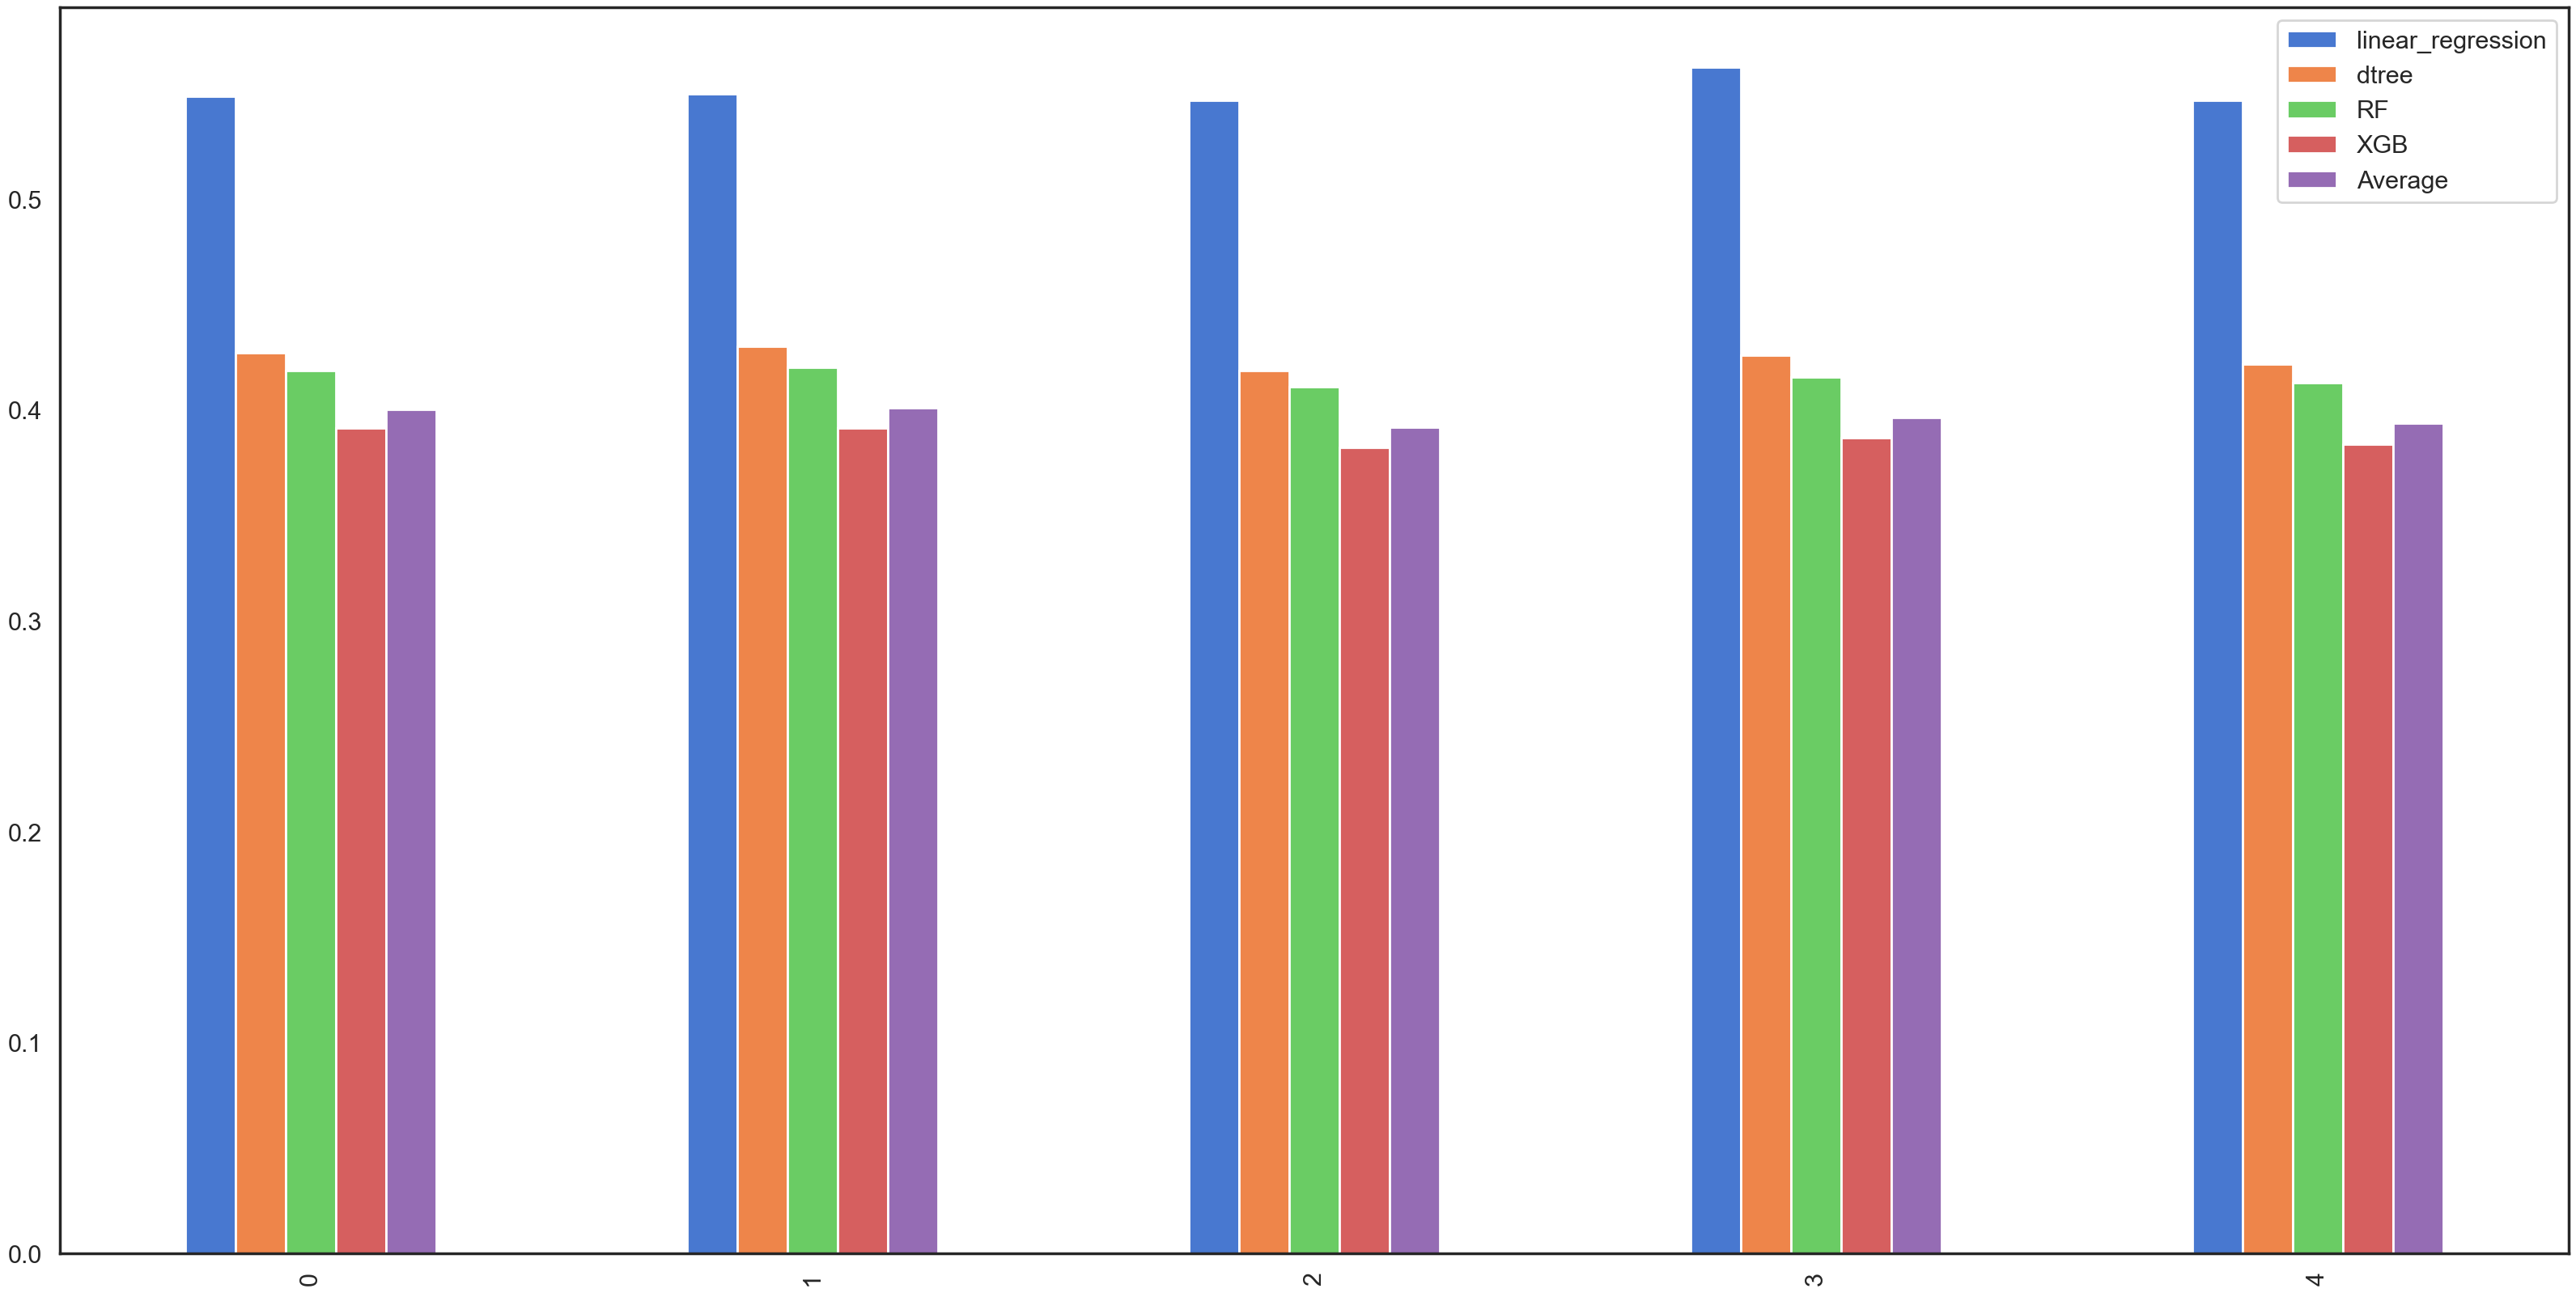

In [82]:
results_df = pd.DataFrame({'linear_regression':linreg_scores, 'dtree': dtree_scores, 'RF':rf_scores, 'XGB': xgb_scores, 'Average': avg_scores})
results_df.plot(y=["linear_regression", "dtree","RF", "XGB","Average"], kind="bar", figsize=(40,20))

XGB does give us the best performance out of all techniques as is clear from the plot above. However, averaging did not perform much better and this is due to the difference in performance of RF and XGBoost. 